# installation

In [1]:
!pip install scikit-image pandas matplotlib tqdm  torchinfo tensorboard wandb

Defaulting to user installation because normal site-packages is not writeable


# Custom PyTorch Dataset

In [2]:
import os
import wandb
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_sched
from torchinfo import summary
import torch.optim as optim
import random
import math
from tqdm import tqdm
import psutil


from typing import Dict

# metrics
from sklearn.metrics import roc_auc_score, accuracy_score

# Config

In [3]:
class CONFIG:
    BATCH_SIZE = 8
    
    # limit the data to prototype faster
    DATA_LIMIT = 50
    
    CLASSES = 3
    DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    ROUND_NUMBER = 3

In [4]:
def format(val : int) -> str:
    if val <= 1024:
        return f"{val}B"
    elif val <= 1024**2:
        return f"{round(val/1024, 2)}KB" 
    elif val <= 1024**3:
        return f"{round(val/(1024**2), 2)}MB" 
    return f"{round(val / (1024**3), 2)}GB"
    

memory_start = psutil.virtual_memory()
print(f"RAM used : {format(memory_start.used)}")

RAM used : 3.02GB


In [5]:
class DeepLenseClassificationDataset(Dataset):

    def __init__(self, folder_path : str, randomize_dataset : bool = True,
                 preprocess_dataset : bool = True, data_limit=0, mean=None, std=None) -> None:
        self.folder_path = folder_path
        self.paths = []
        
        self.class_folders = []     
        self.class_names = [] 
        for class_folder in os.listdir(folder_path):
            full_path = os.path.join(folder_path, class_folder)
            if os.path.isdir(full_path):
                self.class_names.append(class_folder)
                self.class_folders.append(full_path)
        
        self.filepaths = []
        self.classes = []
        self.dataset = []
        
        # craete the classes and filepath arrays
        for class_, class_folder in enumerate(self.class_folders):
            if data_limit <= 0:
                elements = os.listdir(class_folder)
            else :
                elements = os.listdir(class_folder)[:data_limit]        

            for el in elements:
                full_path = os.path.join(class_folder, el)
                self.filepaths.append(full_path)
                self.classes.append(class_)
                                               
        self.filepaths = np.array(self.filepaths)
        self.classes = np.array(self.classes)
        
        # load the dataset
        for filepath in tqdm(self.filepaths, desc="loading numpy"):
            datapoint = np.load(filepath)
            self.dataset.append(datapoint)            
            
        if randomize_dataset:
            self.randomize_dataset()
            
        if mean is None:
            self.mean = np.mean(self.dataset)
        else:
            self.mean = mean

        if std is None:
            self.std = np.std(self.dataset)
        else:
            self.std = std

        if preprocess_dataset:
            for i in tqdm(range(len(self.dataset)), desc="preprocessing"):
                self.dataset[i] = self.preprocess_single(self.dataset[i])

        self.dataset = torch.stack(self.dataset)


    def randomize_dataset(self):
        idxes = np.arange(len(self.filepaths))
        np.random.shuffle(idxes)

        self.filepaths = self.filepaths[idxes]
        self.classes = self.classes[idxes]
        self.dataset = self.dataset[idxes]
    
    def preprocess_single(self, x : np.ndarray) -> torch.Tensor:
        return torch.tensor( (x - self.mean) / self.std).float()

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        return self.dataset[idx], self.classes[idx]

# Test dataset

In [6]:
training_data = DeepLenseClassificationDataset(os.path.join(".", "Dataset", "dataset", "train"), data_limit=CONFIG.DATA_LIMIT, randomize_dataset=False,
                                               mean=None, std=None)
train_dataloader = DataLoader(training_data, batch_size=CONFIG.BATCH_SIZE, shuffle=True)


mean, std = training_data.mean, training_data.std

val_data = DeepLenseClassificationDataset(os.path.join(".", "Dataset", "dataset", "train"), data_limit=CONFIG.DATA_LIMIT, randomize_dataset=False,
                                               mean=mean, std=std)
val_dataloader = DataLoader(training_data, batch_size=CONFIG.BATCH_SIZE, shuffle=True)

preprocessing: 100%|██████████| 150/150 [00:00<00:00, 13457.95it/s]


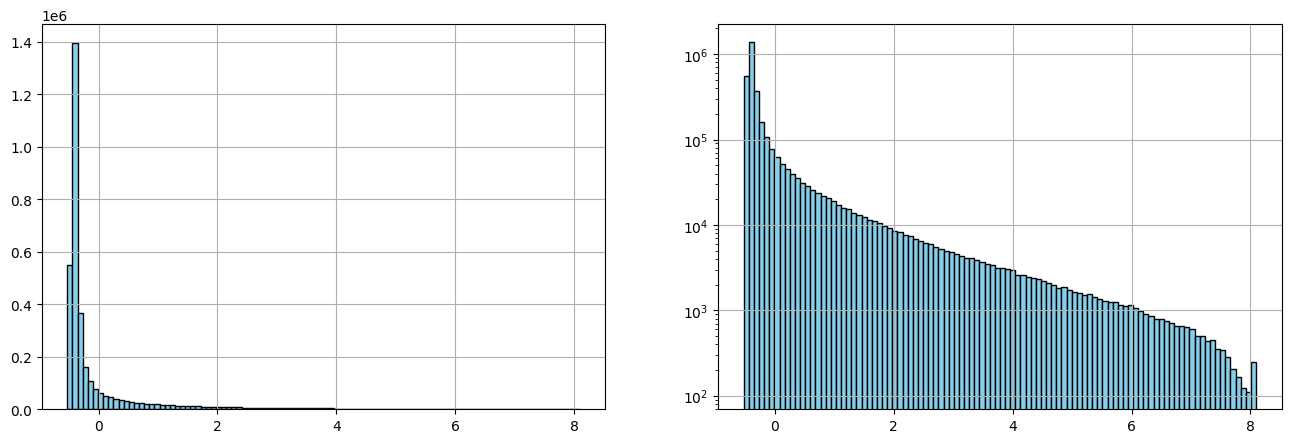

In [7]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.hist(training_data.dataset.numpy().reshape(-1), bins=100, color="skyblue", edgecolor="black")
plt.grid()

plt.subplot(1, 2, 2)
plt.hist(training_data.dataset.numpy().reshape(-1), bins=100, color="skyblue", edgecolor="black")
plt.yscale("log")
plt.grid()
plt.show()

In [8]:
print(f"mean = {training_data.mean.item()} std = {training_data.std.item()}")
print(f"mean_ds  = {torch.mean(training_data.dataset).item()} std = {torch.std(training_data.dataset).item()}")

memory_after = psutil.virtual_memory()
print("")
print(f"RAM used : {format(memory_after.used)}, RAM free : {format(memory_after.free)}, memory used : {format(memory_after.used - memory_start.used)}")

mean = 0.06104566489080949 std = 0.11596657947187662
mean_ds  = 3.2552083251147224e-10 std = 1.0000001192092896

RAM used : 3.08GB, RAM free : 3.24GB, memory used : 62.48MB


In [9]:
plot_size = math.ceil(math.sqrt(CONFIG.BATCH_SIZE))

x, y = next(iter(train_dataloader))
id2name = [v.split("/")[-1] for v in training_data.class_folders] 

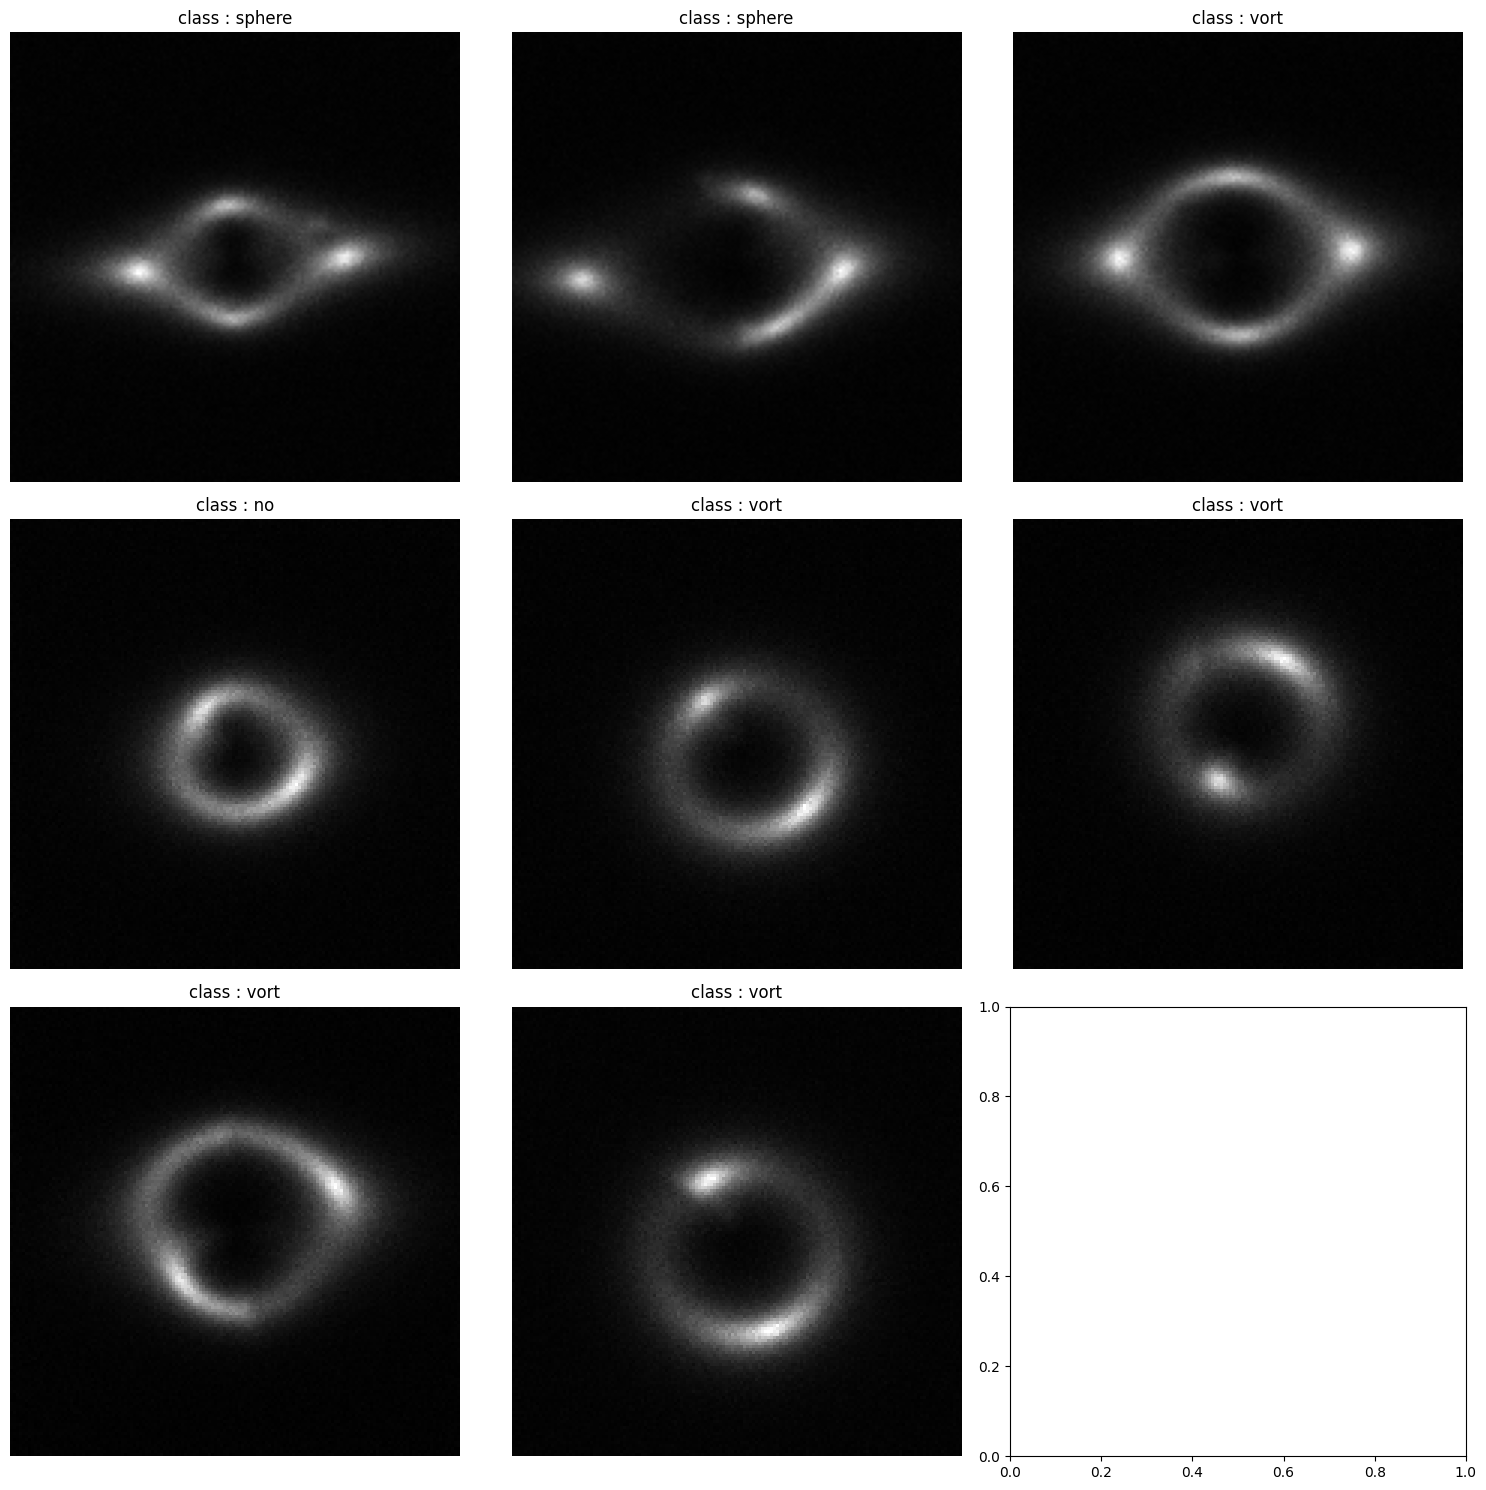

In [10]:
fig, axes = plt.subplots(plot_size, plot_size, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    if i >= len(x):
        break
    # Convert torch tensor to numpy array and transpose channels if necessary
    
    img = x[i].numpy().transpose(1, 2, 0)
    
    ax.imshow(img, cmap="gray")
    ax.set_title(f"class : {id2name[y[i]]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Prototyping the train/val loop

## Model

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNv1(nn.Module):
    def __init__(self):
        super(CNNv1, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) 
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) 
        self.bn2 = nn.BatchNorm2d(64) 
        self.pool = nn.MaxPool2d(2, 2) 

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) 
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1) 
        self.bn4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1) 
        self.bn6 = nn.BatchNorm2d(128) 

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 18 * 18, 256) 
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, CONFIG.CLASSES)

    def forward(self, x):
        # Applying convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.bn2(self.conv2(F.relu(self.bn1(self.conv1(x)))))))
        x = self.pool(F.relu(self.bn4(self.conv4(F.relu(self.bn3(self.conv3(x)))))))
        x = self.pool(F.relu(self.bn6(self.conv6(F.relu(self.bn5(self.conv5(x)))))))

        #print(x.shape)
        # Flattening the output for the fully connected layers
        x = x.view(-1, 128 * 18 * 18)
        #print(x.shape)

        # Fully connected layers with ReLU
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Final layer without ReLU (as it's a classification problem)
        x = self.fc3(x)
        return x

# Create the CNN model instance
model = CNNv1().to(CONFIG.DEVICE)

In [12]:
model(x.float().to(CONFIG.DEVICE))

tensor([[-0.0925, -0.0160, -0.1182],
        [ 0.0204, -0.1074, -0.1595],
        [-0.0190, -0.0175, -0.0715],
        [ 0.0476, -0.0796, -0.0988],
        [-0.0101, -0.1254, -0.1772],
        [ 0.0212, -0.1195,  0.0127],
        [-0.0061, -0.0373, -0.0382],
        [ 0.0108, -0.0446, -0.1430]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

## Util function

In [15]:
def test(model : nn.Module, val_dataset : DataLoader,  run = None):
    
    # change the model to evaluation
    model.eval()
    
    # get the number of datapoints
    number_of_datapoints = len(val_dataset.dataset)    

    # allocate the memory for these datapoints (no need to keep appending the data, which will make it slower)
    predictions_prob = np.zeros((number_of_datapoints, CONFIG.CLASSES))
    predictions = np.zeros(number_of_datapoints)
    true_values = np.zeros(number_of_datapoints) 
    

    # get the number of batches
    dataset_len = len(val_dataset)

    # create the progreess bar 
    pbar = tqdm(val_dataset)

    # variable that will track where we are in terms of all data (after iteration add batch size to it)
    c = 0
    for i, (x,y) in enumerate(pbar): 
        # get the predictions
        pred = model(x.to(CONFIG.DEVICE))
 
        # get the batch size
        bs = x.shape[0]

        true_values[c : (c + bs)] = y.detach().numpy()
        predictions_prob[c : (c + bs)] = torch.softmax(pred.cpu().detach(), dim=1).numpy()
        predictions[c : (c + bs)] = torch.argmax(pred, 1).cpu().detach().numpy()
        c += bs 
           
        if i % (dataset_len//10) == 0 or i == dataset_len -1:
            acc = accuracy_score(predictions[:c], true_values[:c])
            try:
                roc_auc = roc_auc_score(true_values[:c], predictions_prob[:c, :], multi_class='ovr')            
            
            # It can happen at the beginning
            except Exception as e:
                roc_auc = 0

            pbar.set_description(f"examples seen so far : {c}, accuracy = {round(acc, CONFIG.ROUND_NUMBER)}, AUC ROC = {round(roc_auc, CONFIG.ROUND_NUMBER)}")
    
    return {"predition_prob" : predictions_prob, "predictions" : predictions, "true" : true_values}

def report_metrics(results : Dict, epoch : int, WANDB_ON : bool = True, run=None) -> Dict:
    predictions = results["predictions"]
    true_values = results["true"]
    predictions_prob = results["predition_prob"]
    
    acc = accuracy_score(predictions, true_values)
    roc_auc_ovr = roc_auc_score(true_values, predictions_prob, multi_class='ovr')            
    roc_auc_ovo = roc_auc_score(true_values, predictions_prob, multi_class='ovo')  
    
    if WANDB_ON:
        wandb.log({"val_acc": acc, "val_ROC_AUC_ovr": roc_auc_ovr, "val_ROC_AUC_ovo" : roc_auc_ovo})
        wandb.log({f"ROC_epoch={epoch}" : wandb.plot.roc_curve(true_values, predictions_prob, labels=val_data.class_names)})
    
    return {"accuracy" : acc, "ROC_AUC_OVR" :  roc_auc_ovr, "ROC_AUC_OVO" : roc_auc_ovo}


def save_model(model : nn.Module, metrics_results : Dict, metric_keyword : str, best_metric : float, savepath : str):
    
    if metrics_results[metric_keyword] > best_metric:
        torch.save(model.state_dict(), savepath)
        
    return max(metrics_results[metric_keyword], best_metric)

def train(model : nn.Module, 
          optimizer : optim.Optimizer, 
          scheduler : lr_sched.LRScheduler, 
          criterion, 
          epoch : int, 
          WANDB_ON : bool=True):
    model.train()
    running_loss = 0.0
    i = 1
    train_len = len(train_dataloader)
    
    pb = tqdm(train_dataloader)
    for inputs, labels in pb:
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs.to(CONFIG.DEVICE))
        loss = criterion(outputs, labels.to(CONFIG.DEVICE))
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        if scheduler is not None:
            scheduler.step()  # Update learning rate
        
        running_loss += loss.item()
        
        if (i-1) % (train_len//10) == 0 or i == train_len:      
            pb.set_description(f"EPOCH : {epoch}, average loss : {running_loss / i}")
        i += 1
    
    if WANDB_ON:
        wandb.log({"loss" : running_loss/len(train_dataloader)})

    

def run_experiment(Model : nn.Module, 
                   run_name : str, 
                   model_parameters : dict, 
                   epochs : int, 
                   learning_rate : float, 
                   optimizer : str, 
                   savepath : str,
                   base_lr:float=1e-4, 
                   max_lr:float=1e-3, 
                   scheduler_en : bool = True,
                   metric_keyword : str = "acc",
                   lr_steps : int = 1000,
                   WANDB_ON : bool = True):

    try:
        os.mkdir("models") 
    except FileExistsError:
        pass
    
    model = Model(**model_parameters).to(CONFIG.DEVICE)
    
    config = {"model name" : model.__class__,
              "run name" : run_name,
              "epochs" : epochs,
              "learning rate" : learning_rate,
              "optimizer" : optimizer, 
              "uses scheduler" : scheduler_en,
              "base_lr" : base_lr,
              "max_lr" : max_lr,
              "lr_steps" : lr_steps}
    
    config.update(model_parameters)    
    
    model_summary_str = str(summary(model, input_size=(CONFIG.BATCH_SIZE, 1, 150, 150)))
        
    if WANDB_ON:
        run = wandb.init(project="DeepLense2024_task1",
                     name=f"experiment_{run_name}",
                     notes="Model summary : \n" + model_summary_str,
                     config=config)

    
    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    if optimizer.lower() == "adam":
        optimizer_ = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer.lower() == "adamw":
        optimizer_ = optim.AdamW(model.parameters(), lr=learning_rate)
    else:
        raise Exception("specify correctly the optimizer !")

    # Set up CyclicLR scheduler
    scheduler = None
    if scheduler_en:
        scheduler = lr_sched.CyclicLR(optimizer_, base_lr=base_lr, max_lr=max_lr, step_size_up=lr_steps, mode='triangular')

    best_metric = 0 
    
    for epoch in range(epochs):
        train(model, optimizer_, scheduler, criterion, epoch=epoch, WANDB_ON=WANDB_ON)
        test_res = test(model, val_dataloader)
        evaluation = report_metrics(test_res, epoch=epoch, WANDB_ON=WANDB_ON)
        best_metric = save_model(model, evaluation, metric_keyword, best_metric, savepath)
    
    if WANDB_ON:
        wandb.finish()

## Run experiment

In [16]:
run_experiment(Model=CNNv1, 
               run_name="Simplest/testrun", 
               model_parameters={},
               epochs=30,
               learning_rate=3e-4,
               optimizer="AdamW",
               savepath=os.path.join("models", "testrun.cfg"),
               base_lr=1e-4,
               max_lr=1e-3,
               scheduler_en=False,
               metric_keyword="accuracy",
               lr_steps=len(train_dataloader) // 2,
               WANDB_ON=True)

EPOCH : 0, average loss : 1.3922579884529114: 100%|██████████| 19/19 [00:00<00:00, 25.84it/s]
examples seen so far : 150, accuracy = 0.393, AUC ROC = 0.68: 100%|██████████| 19/19 [00:00<00:00, 86.34it/s] 
EPOCH : 1, average loss : 1.123949784981577: 100%|██████████| 19/19 [00:00<00:00, 44.32it/s] 
examples seen so far : 150, accuracy = 0.48, AUC ROC = 0.744: 100%|██████████| 19/19 [00:00<00:00, 85.32it/s] 
EPOCH : 2, average loss : 1.0327282830288536: 100%|██████████| 19/19 [00:00<00:00, 45.45it/s]
examples seen so far : 150, accuracy = 0.533, AUC ROC = 0.758: 100%|██████████| 19/19 [00:00<00:00, 72.61it/s]
EPOCH : 3, average loss : 0.9855053644431265: 100%|██████████| 19/19 [00:00<00:00, 31.59it/s]
examples seen so far : 150, accuracy = 0.56, AUC ROC = 0.805: 100%|██████████| 19/19 [00:00<00:00, 90.14it/s] 
EPOCH : 4, average loss : 0.9810398911174975: 100%|██████████| 19/19 [00:00<00:00, 45.67it/s]
examples seen so far : 150, accuracy = 0.627, AUC ROC = 0.841: 100%|██████████| 19/19 

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


loss,█▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_ROC_AUC_ovo,▁▂▃▄▅▅▆▆▇▇▇███▇███████████████
val_ROC_AUC_ovr,▁▂▃▄▅▅▆▆▇▇▇███▇███████████████
val_acc,▁▂▃▃▄▄▅▅▆▆▆▆▇▇▄███████████████
loss,0.00174
val_ROC_AUC_ovo,1.0
val_ROC_AUC_ovr,1.0
val_acc,1.0


__main__.CNNv1